In [1]:
import numpy as np
import scipy.io
import pandas as pd
import pickle
from itertools import product
from typing import *
import os
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from fastplotlib import Plot

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from scipy.io import loadmat

m = loadmat("/home/kushalk/repos/rnn-go-brr/rnngobrr/yuechen_data.mat")
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_directions_v2', 'direction_YQ1', 'realigned_traj_v2', 'traj_YQ1'])

In [4]:
directions = m["direction_YQ1"].flatten() - 1
np.unique(directions)
directions

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=uint8)

In [5]:
a = m['traj_YQ1']

traj_origin = (a.T - a[:, :, 0].T).T

In [6]:
traj_origin.shape

(156, 3, 151)

In [7]:
traj = np.zeros((traj_origin.shape[0], traj_origin.shape[1] + 1, traj_origin.shape[2]-1))
traj[:, :3, :] = traj_origin[:, :, 1:]
traj[:, -1, :] = directions.reshape(-1, 1)

### `[n_trials, x-y-z-target_direction, n_timepoints]`

In [8]:
inputs = dict()
targets = dict()
for i, d in zip(range(3), ["x", "y", "z"]):
    inputs[d] = torch.tensor(traj[:, i, 0], dtype=torch.float32)
    targets[d] = torch.tensor(traj[:, i, :], dtype=torch.float32)

In [9]:
inputs["x"].shape

torch.Size([156])

In [10]:
inputs["x"]

tensor([ 2.7786e-01,  1.6708e-01, -1.5380e-01,  2.8859e-01,  2.1227e-01,
         1.9987e-01,  1.1053e-02,  5.9409e-02, -4.2371e-02,  3.2514e-01,
         1.3058e-01,  2.1968e-02,  1.3173e-01, -6.9887e-02, -6.9164e-02,
        -1.2414e-01,  1.4844e-01, -1.7066e-01, -1.0156e-01,  4.0183e-01,
         3.5782e-02,  6.8470e-02, -3.8421e-01,  3.9055e-01,  1.9090e-01,
         5.0985e-02, -3.2464e-01,  3.2621e-01, -4.3204e-01, -5.3776e-02,
        -9.8405e-03,  4.4364e-01,  1.2213e-02, -5.2573e-02, -1.4205e-02,
         2.0583e-01,  3.0787e-03,  7.8139e-02, -1.5844e-01,  1.2556e-01,
        -4.9801e-02,  7.5770e-02,  1.4970e-01, -8.4451e-02, -7.5568e-02,
         2.2799e-01,  1.7150e-01,  1.0482e-02,  2.1809e-01, -1.2406e-01,
        -4.8354e-03,  2.5671e-01, -9.0102e-02,  1.4876e-02, -6.0885e-02,
         8.9228e-02, -1.5578e-01,  3.2629e-01, -1.4811e-02,  3.0648e-01,
        -6.7027e-04,  3.0187e-01,  2.8693e-02,  2.4420e-01, -3.9270e-02,
         3.4682e-02,  5.1562e-02,  3.2521e-01, -2.1

In [11]:
targets["x"].shape

torch.Size([156, 150])

In [36]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

hidden_size = 500
input_size = 1
output_size = 1
lr = 0.01


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)

        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev



model = Net().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 156, hidden_size).cuda()

n_epochs = 1000
for n_epoch in tqdm(range(n_epochs)):
    x = targets["x"].reshape(156, 150, 1)
    y = targets["x"].reshape(156, 150, 1)

    output, hidden_prev = model(x.cuda(), hidden_prev)
    hidden_prev = hidden_prev.detach()

    # print(f"output {output.shape}, y {y.shape}")
    loss = criterion(output, y.cuda())
    model.zero_grad()
    # optimizer.zero_grad()
    # both zero_grad() are the same if model.parameters() is feed to the same optimizer
    # only matters if multiple models using same optimizer or multiple optims used for a model
    loss.backward()
    optimizer.step()

100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.97it/s]


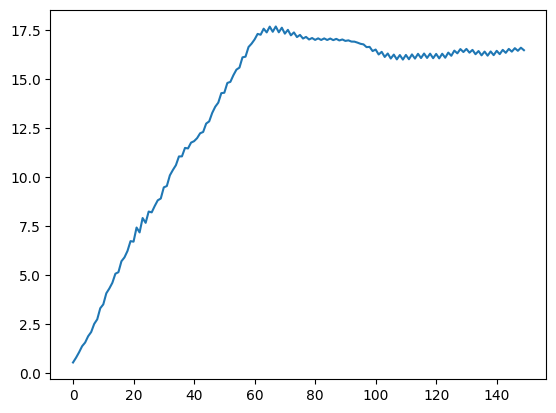

In [37]:
plt.plot(output.detach().cpu().numpy()[0, 0, :, 0])